In [1]:
# Section must be included at the beginning of each new notebook. Remember to change the app name.
# If you're using VirtualBox, change the below to '/home/user/spark-2.1.1-bin-hadoop2.7'
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import *

# If you're getting an error with numpy, please type 'sudo pip3 install numpy --user' into the console.
# If you're getting an error with another package, type 'sudo pip3 install PACKAGENAME --user'. 
# Replace PACKAGENAME with the relevant package (such as pandas, etc).
from pyspark.ml.classification import LogisticRegression

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,OneHotEncoder,StringIndexer)

In [2]:
spark = SparkSession.builder.appName('data_modelling_wq').getOrCreate()

In [3]:
# Import data and print schema - columns is another way to view the data's features.
df = spark.read.csv('clean_data.csv', header=True, inferSchema=True)
# df = spark.read.csv('clean_data2.csv', header=True, inferSchema=True)
df.printSchema()
df.toPandas().describe()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- Wine color: string (nullable = true)
 |-- quality: string (nullable = true)



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,density,pH,sulphates,alcohol
count,4871.000000,4871.000000,4871.000000,4871.000000,4871.000000,4871.000000,4871.000000,4871.000000,4871.000000,4871.000000
mean,7.200831,0.336697,0.312763,5.163375,0.053538,30.165777,0.994534,3.225481,0.526145,10.551699
std,1.257394,0.162306,0.135072,4.535988,0.026393,17.643337,0.002923,0.151659,0.132850,1.165721
min,4.400000,0.080000,0.000000,0.600000,0.012000,1.000000,0.987110,2.790000,0.220000,8.400000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,0.992230,3.120000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,2.800000,0.047000,28.000000,0.994610,3.220000,0.510000,10.400000
75%,7.700000,0.390000,0.390000,7.700000,0.063000,41.000000,0.996750,3.330000,0.600000,11.300000
max,14.200000,1.100000,1.660000,65.800000,0.415000,289.000000,1.038980,3.750000,1.980000,14.200000


In [4]:
# First create a string indexer which converts every string into a number, such as male = 0 and female = 1.
# A number will be assigned to every category in the column.
wine_color_indexer = StringIndexer(inputCol='Wine color',outputCol='wine_colorIndex')
quality_indexer = StringIndexer(inputCol='quality',outputCol='label')

# Now we can one hot encode these numbers. This converts the various outputs into a single vector.
# Multiple columns are collapsed into one. 
# This makes it easier to process when you have multiple classes.
wine_color_encoder = OneHotEncoder(inputCol='wine_colorIndex',outputCol='wine_colorVec')
# quality_encoder = OneHotEncoder(inputCol='qualityIndex',outputCol='qualityVec')

# And finally, using vector assembler to turn all of these columns into one column (named features).
assembler = VectorAssembler(inputCols=['fixed acidity','volatile acidity','citric acid','residual sugar',
                                       'chlorides','free sulfur dioxide','density','pH',
                                       'sulphates', 'alcohol', 'wine_colorVec'], outputCol="features")
# assembler = VectorAssembler(inputCols=['fixed acidity','volatile acidity','citric acid','residual sugar',
#                                        'chlorides','free sulfur dioxide','total sulfur dioxide','density','pH',
#                                        'sulphates', 'alcohol', 'wine_colorVec'], outputCol="features")

In [5]:
# Then go through our steps. It's essentially sequential to the above.
pipeline = Pipeline(stages=[wine_color_indexer, quality_indexer, wine_color_encoder, assembler])
# Now that we've got a number of steps, let's apply it to the DataFrame.
pipeline_model = pipeline.fit(df)

# Incorporate results into a new DataFrame.
pipe_df = pipeline_model.transform(df)

# Remove all variables other than features and label. 
pipe_df.select('Wine color', 'wine_colorIndex', 'quality', 'label').show()
pipe_df = pipe_df.select('label', 'features')
pipe_df.head(1)

+----------+---------------+-------+-----+
|Wine color|wine_colorIndex|quality|label|
+----------+---------------+-------+-----+
|     White|            0.0|    bad|  1.0|
|       Red|            1.0|    bad|  1.0|
|       Red|            1.0|   good|  0.0|
|     White|            0.0|   good|  0.0|
|     White|            0.0|   good|  0.0|
|     White|            0.0|   good|  0.0|
|     White|            0.0|    bad|  1.0|
|     White|            0.0|    bad|  1.0|
|       Red|            1.0|   good|  0.0|
|       Red|            1.0|    bad|  1.0|
|     White|            0.0|   good|  0.0|
|     White|            0.0|    bad|  1.0|
|       Red|            1.0|   good|  0.0|
|     White|            0.0|   good|  0.0|
|     White|            0.0|   good|  0.0|
|       Red|            1.0|   good|  0.0|
|       Red|            1.0|   good|  0.0|
|     White|            0.0|    bad|  1.0|
|     White|            0.0|   good|  0.0|
|       Red|            1.0|   good|  0.0|
+----------

[Row(label=1.0, features=DenseVector([6.0, 0.28, 0.29, 19.3, 0.051, 36.0, 0.9991, 3.14, 0.5, 9.0, 1.0]))]

In [6]:
def evaluate_indicators(predictions, col_name):
    tp = predictions.filter("label = prediction and label=0.0").count()
    tn = predictions.filter("label = prediction and label=1.0").count()
    fp = predictions.filter("label <> prediction and label=0.0").count()
    fn = predictions.filter("label <> prediction and label=1.0").count()
    num = predictions.count()
    acc = (tp+tn)/num
    pre = tp/(tp+fp)
    rec = tp/(tp+fn)
    eval_dict = {
        'Accuracy': acc,
        'Precision': pre,
        'Recall': rec,
        'F1-score': 2*pre*rec/(pre+rec)
    }
    eval_pd = pd.DataFrame.from_dict(eval_dict, orient='index')
    eval_pd.columns = [col_name]
    return eval_pd

In [7]:
# Decision Tree
from pyspark.ml.classification import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(featuresCol='features', \
                                  labelCol='label',
                                  maxDepth=5) 

paramGrid = ParamGridBuilder().build()
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=dt_model, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
# Run cross validations
cvModel_dt = cv.fit(pipe_df)

In [8]:
dt_model = cvModel_dt.bestModel

dt_mol = dt_model.transform(pipe_df)
eva_dt = evaluate_indicators(dt_mol, "DecisionTreeClassifier(Cross validation)")

In [9]:
feature_i_dt = dt_model.featureImportances
pd.DataFrame(feature_i_dt.toArray(), index=['fixed acidity','volatile acidity','citric acid','residual sugar',
                      'chlorides','free sulfur dioxide','density','pH',
                      'sulphates', 'alcohol', 'wine_colorVec'], columns=["importance"]).sort_values('importance', ascending=False)

,importance
alcohol,0.556650
volatile acidity,0.209681
sulphates,0.091096
free sulfur dioxide,0.086184
chlorides,0.018764
residual sugar,0.013600
fixed acidity,0.011183
density,0.007482
pH,0.005360
citric acid,0.000000


In [10]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Area Under ROC: " + str(evaluator.evaluate(dt_mol, {evaluator.metricName: "areaUnderROC"})))

Area Under ROC: 0.7679102104820075


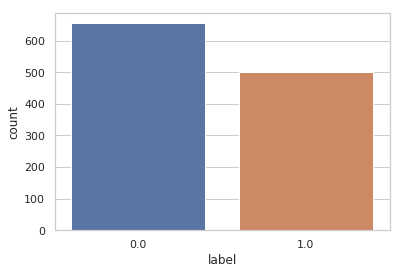

In [11]:
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

sns.countplot(x='label', data=dt_mol.filter('label <> prediction').toPandas())

In [12]:
# Logistic Regression
lr_model = LogisticRegression(featuresCol='features', \
                              labelCol='label', \
                              regParam=0.0, \
                              elasticNetParam=0.0, \
                              maxIter=100) 

paramGrid=ParamGridBuilder().build()
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=lr_model, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
# Run cross validations
cvModel_lr = cv.fit(pipe_df)

In [13]:
lr_res = cvModel_lr.bestModel.summary.predictions
eva_lr = evaluate_indicators(lr_res, "LogisticRegression(Cross validation)")

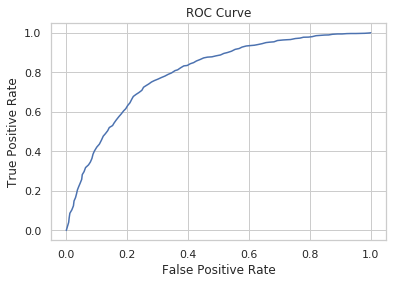

Area Under the Curve: 0.7961217728109492


In [14]:
bestModel_summary = cvModel_lr.bestModel.summary

# training_summary.accuracy.show()
# Convert the DataFrame to a Pandas DataFrame.
ROC = bestModel_summary.roc.toPandas()
# Plot the true positive and false positive rates.
sns.lineplot(x='FPR', y='TPR', data=ROC)

# Define the labels.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print the AUC statistic. 
print('Area Under the Curve: ' + str(bestModel_summary.areaUnderROC))

In [15]:
# More iteration
lr_model = LogisticRegression(featuresCol='features',labelCol='label') 

paramGrid = ParamGridBuilder().addGrid(lr_model.regParam, [0.0, 0.3]).\
addGrid(lr_model.elasticNetParam, [0.0, 0.8]).\
addGrid(lr_model.maxIter, [100, 10]).build()

evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=lr_model, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
# Run cross validations
cvModel = cv.fit(pipe_df)


In [16]:
lr_res = cvModel.bestModel.summary.predictions
evaluate_indicators(lr_res, "LogisticRegression(Cross validation)")

,LogisticRegression(Cross validation)
Precision,0.823165
Recall,0.770382
F1-score,0.795899
Accuracy,0.734346


In [17]:
from pyspark.ml.classification import RandomForestClassifier
# Instantiate the model.
rf_model = RandomForestClassifier(featuresCol='features',\
                                  labelCol='label', \
                                  maxDepth=5, 
                                  numTrees=20)

paramGrid=ParamGridBuilder().build()
evaluator = MulticlassClassificationEvaluator()
cv = CrossValidator(estimator=rf_model, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
# Run cross validations
cvModel_rf = cv.fit(pipe_df)

In [18]:
rf_model = cvModel_rf.bestModel

rf_mol = rf_model.transform(pipe_df)
eva_rf = evaluate_indicators(rf_mol, "RandomForestClassifier(Cross validation)")

In [19]:
feature_i_rf = rf_model.featureImportances
pd.DataFrame(feature_i_rf.toArray(), index=['fixed acidity','volatile acidity','citric acid','residual sugar',
                      'chlorides','free sulfur dioxide','density','pH',
                      'sulphates', 'alcohol', 'wine_colorVec'], columns=["importance"]).sort_values('importance', ascending=False)

,importance
alcohol,0.360991
density,0.157239
volatile acidity,0.149488
sulphates,0.078059
chlorides,0.072237
free sulfur dioxide,0.054853
citric acid,0.044973
residual sugar,0.038123
fixed acidity,0.024675
pH,0.017937


In [20]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Area Under ROC: " + str(evaluator.evaluate(rf_mol, {evaluator.metricName: "areaUnderROC"})))

Area Under ROC: 0.8524770612368795


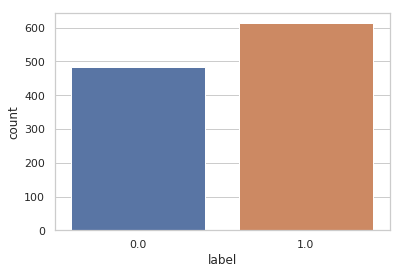

In [21]:
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

sns.countplot(x='label', data=rf_mol.filter('label <> prediction').toPandas())

In [22]:
from pyspark.ml.classification import RandomForestClassifier
# Instantiate the model.
rf_model = RandomForestClassifier(featuresCol='features',\
                                  labelCol='label')

paramGrid = ParamGridBuilder().addGrid(rf_model.numTrees, [i for i in range(15, 25)]).build()
evaluator = MulticlassClassificationEvaluator()
cv = CrossValidator(estimator=rf_model, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
# Run cross validations
cvModel = cv.fit(pipe_df)

In [23]:
rfs_model = cvModel.bestModel

rfs_mol = rfs_model.transform(pipe_df)
evaluate_indicators(rfs_mol, "RandomForestClassifier(Cross validation)")

,RandomForestClassifier(Cross validation)
Precision,0.852855
Recall,0.804060
F1-score,0.827739
Accuracy,0.776637


In [24]:
# gradient boosting tree 
from pyspark.ml.classification import GBTClassifier
gbt_model = GBTClassifier(labelCol="label", \
                          featuresCol="features", \
                          maxIter=10)
paramGrid=ParamGridBuilder().build()
evaluator = MulticlassClassificationEvaluator()
cv = CrossValidator(estimator=gbt_model, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
# Run cross validations
cvModel_gbt = cv.fit(pipe_df)

In [25]:
gbt_model = cvModel_gbt.bestModel

gbt_mol = gbt_model.transform(pipe_df)
eva_gbt = evaluate_indicators(gbt_mol, "GBTClassifier(Cross validation)")
feature_i = gbt_model.featureImportances

In [26]:
pd.DataFrame(feature_i.toArray(), index=['fixed acidity','volatile acidity','citric acid','residual sugar',
                      'chlorides','free sulfur dioxide','density','pH',
                      'sulphates', 'alcohol', 'wine_colorVec'], columns=["importance"]).sort_values('importance', ascending=False)

,importance
alcohol,0.181367
free sulfur dioxide,0.116828
sulphates,0.113648
volatile acidity,0.098524
residual sugar,0.098300
fixed acidity,0.093208
pH,0.087294
citric acid,0.080157
chlorides,0.072421
density,0.045602


In [27]:
evaluator = BinaryClassificationEvaluator(labelCol="label", \
                                          rawPredictionCol="prediction")
print(type(gbt_model))
gbt_mol.printSchema()
print("Area Under ROC: " + str(evaluator.evaluate(gbt_mol, {evaluator.metricName: "areaUnderROC"})))

<class 'pyspark.ml.classification.GBTClassificationModel'>
root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: double (nullable = true)

Area Under ROC: 0.7865074547592853


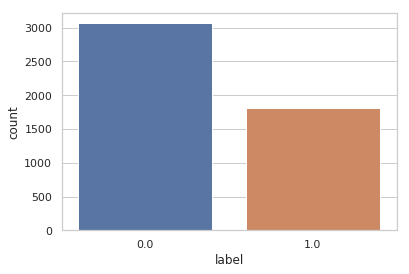

In [28]:
sns.countplot(x='label', data=gbt_mol.toPandas())

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|  1.0|[6.0,0.28,0.29,19...|       1.0|
|  1.0|[10.0,0.69,0.11,1...|       1.0|
|  0.0|[7.2,0.36,0.46,2....|       0.0|
|  0.0|[6.0,0.33,0.38,9....|       0.0|
|  0.0|[5.9,0.15,0.31,5....|       0.0|
|  0.0|[6.4,0.35,0.28,12...|       1.0|
|  1.0|[7.5,0.26,0.52,13...|       1.0|
|  1.0|[6.4,0.25,0.57,1....|       1.0|
|  0.0|[6.3,0.55,0.15,1....|       0.0|
|  1.0|[5.8,0.68,0.02,1....|       1.0|
|  0.0|[7.3,0.29,0.29,4....|       0.0|
|  1.0|[5.8,0.15,0.49,1....|       0.0|
|  0.0|[12.6,0.38,0.66,2...|       0.0|
|  0.0|[6.6,0.26,0.29,1....|       0.0|
|  0.0|[6.8,0.26,0.42,1....|       0.0|
|  0.0|[6.4,0.865,0.03,3...|       0.0|
|  0.0|[6.0,0.54,0.06,1....|       0.0|
|  1.0|[7.0,0.15,0.34,1....|       0.0|
|  0.0|[6.6,0.2,0.14,4.4...|       0.0|
|  0.0|[7.3,0.33,0.47,2....|       1.0|
+-----+--------------------+----------+
only showing top 20 rows



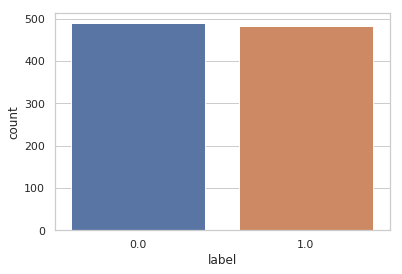

In [29]:
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
gbt_mol.show()
sns.countplot(x='label', data=gbt_mol.filter('label <> prediction').toPandas())

In [30]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

gbt_model = GBTClassifier(labelCol="label", \
                          featuresCol="features")
paramGrid=ParamGridBuilder().addGrid(gbt_model.maxIter, [i for i in range(10, 18)]).build()
evaluator = MulticlassClassificationEvaluator()
cv = CrossValidator(estimator=gbt_model, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
# Run cross validations
cvModel_gbts = cv.fit(pipe_df)

In [31]:
gbts_model = cvModel_gbts.bestModel

gbts_mol = gbts_model.transform(pipe_df)
evaluate_indicators(gbts_mol, "GBTClassifier(Cross validation)")

,GBTClassifier(Cross validation)
Precision,0.854160
Recall,0.853603
F1-score,0.853881
Accuracy,0.816054


In [32]:
pd.concat([eva_dt,eva_lr,eva_rf,eva_gbt], axis=1)

,DecisionTreeClassifier(Cross validation),LogisticRegression(Cross validation),RandomForestClassifier(Cross validation),GBTClassifier(Cross validation)
Precision,0.786297,0.823165,0.842741,0.840457
Recall,0.827894,0.770382,0.808198,0.842105
F1-score,0.806560,0.795899,0.825108,0.841280
Accuracy,0.762677,0.734346,0.775200,0.800452


In [33]:
pd.concat([eva_gbt,eva_rf,eva_dt], axis=1)

,GBTClassifier(Cross validation),RandomForestClassifier(Cross validation),DecisionTreeClassifier(Cross validation)
Precision,0.840457,0.842741,0.786297
Recall,0.842105,0.808198,0.827894
F1-score,0.841280,0.825108,0.806560
Accuracy,0.800452,0.775200,0.762677


In [34]:
from pyspark.ml.classification import NaiveBayes

nb_model = NaiveBayes(labelCol="label", \
                          featuresCol="features", smoothing=1.0)
paramGrid=ParamGridBuilder().build()
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=nb_model, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
# Run cross validations
cvModel_nb = cv.fit(pipe_df)

In [35]:
nb_model = cvModel_nb.bestModel

nb_mol = nb_model.transform(pipe_df)
eva_gbt = evaluate_indicators(nb_mol, "NaiveBayes(Cross validation)")
print(eva_gbt)

           NaiveBayes(Cross validation)
Precision                      0.853181
Recall                         0.651632
F1-score                       0.738909
Accuracy                       0.620612
